##### João Vitor Cardoso <2019>

# Desenhar trajetoria

Desenhar a trajetória de um carrinho apartir de uma sequência de imagens

## Importando Bibliotecas 

In [1]:
import cv2
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, interact_manual

## Explorando Dados

In [2]:
# Conjunto de imagens {nome da imagem: [Original, Escala de cinza  }
images = {}
ORIG = 0
GRAY = 1

# Imagem utilizada como referência
img = None

# Caminho dos dados
FILEPATH = "data/"

# Carregar imagens 
for x in range(3, 16):
 
    # Nome da imagem
    label = "shot%.4d.png" %x

    # Caminho do imagem
    path = FILEPATH + label

    # Carregar a imagem na cor BGR (Padrão Opencv)
    orig = cv2.imread(path, cv2.IMREAD_COLOR)

    # Converter para RGB
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    # Carregar imagem em escala de cinza
    gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)

    # Salvando imagens no dicionario
    images[label] = [orig, gray]

# Visualizando imagem selecionada
def view_image(label):
    
    # Referênciando variavel global
    global images, img

    # Definindo imagem de referência
    img = images[label]
    
    # Recuperando imagem 
    orig = img[ORIG]
    gray = img[GRAY]

    # Plotar imagens
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(orig)
    ax[1].imshow(gray, 'gray')

# Selecionar imagem apartir da escolha do usuário
interactive(view_image, label=images.keys())
    

interactive(children=(Dropdown(description='label', options=('shot0003.png', 'shot0004.png', 'shot0005.png', '…

### Criando imagem de plano de fundo

In [3]:
# Obtendo a largura da imagem
height = img[0].shape[1]

# Criando imagem de plano de fundo
background = None

# Função para criar plano de fundo
def create_background(h=12, label='shot0003.png', label2='shot0009.png'):
    global images, background, height

    if h != 0:
        # Ajustando a escala
        h = h*100
        
        # Carregando imagem 1 e 2
        img1 = images[label][ORIG]
        img2 = images[label2][ORIG]
        
        # Criando uma copia da imagem 1
        img1 = img1.copy()
        
        # Criando copia de uma parte da imagem 2, apartir do ponto h*100, sobreescrevendo copia da imagem 1. 
        img1[0:-1, h:-1] = img2[0:-1, h:-1].copy()
        
        # Obtendo versão em escala de cinza
        gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
        
        # Salvando imagem
        background = (img1, gray)
        
    # Mostrando
    plt.imshow(img1, 'gray')

interactive(create_background, h=(0, int(height/100) ), label=images.keys(), label2=images.keys())

interactive(children=(IntSlider(value=12, description='h', max=19), Dropdown(description='label', options=('sh…

## Selecionando Carrinho

In [4]:
# Conjunto de imagens {nome da imagem: [Original, 
#                                       Escala de cinza, 
#                                       Diferença entre plano de fundo e a escala de cinda] }
CHANGE = 2

for key, value in images.items():
    value.append(cv2.absdiff(background[GRAY], value[GRAY]))

# Visualizando diferença entre as imagens
def view_diff(label):
    
    # Referênciando variavel global
    global images
    
    # Recuperando imagem 
    gray = images[label][GRAY]
    change = images[label][CHANGE]

    # Plotar imagens
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(gray, 'gray')
    ax[1].imshow(change, 'gray')

# Selecionar imagem apartir da escolha do usuário
interactive(view_diff, label=images.keys())

interactive(children=(Dropdown(description='label', options=('shot0003.png', 'shot0004.png', 'shot0005.png', '…

## Aplicando Filtro

In [5]:
# Conjunto de imagens {nome da imagem: [Original, 
#                                       Escala de cinza, 
#                                       Diferença entre plano de fundo e a escala de cinda,
#                                       Imagem filtrada] }
FILTER = 3

# Adicionando espaço para filtro nas imagens
for key, value in images.items():
    value.append(None)

# Filtros do cv2
modes = ['cv2.THRESH_BINARY',
         'cv2.THRESH_BINARY_INV',
         'cv2.THRESH_TRUNC',
         'cv2.THRESH_TOZERO',
         'cv2.THRESH_TOZERO_INV']


# Threshold basico
def my_threshold(label, thresh, modeStr):
    mode = eval(modeStr)

    # Aplicando threshold em todas as imagens
    for key, value in images.items():
        th, dst  = cv2.threshold(value[CHANGE], thresh, 255, mode)
        value[FILTER] = dst
        
    # Recuperando imagem 
    gray = images[label][GRAY]
    fil = images[label][FILTER]

    # Plotar imagens
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(gray, 'gray')
    ax[1].imshow(fil, 'gray')

# Selecionar imagem apartir da escolha do usuário
interactive(my_threshold, label=images.keys(), modeStr=modes, thresh = (0, 255))

interactive(children=(Dropdown(description='label', options=('shot0003.png', 'shot0004.png', 'shot0005.png', '…

## Refinando imagem filtrada

In [6]:
# Conjunto de imagens {nome da imagem: [Original, 
#                                       Escala de cinza, 
#                                       Diferença entre plano de fundo e a escala de cinda,
#                                       Imagem filtrada,
#                                       Imagem com menos ruido] }
RESULT = 4

# Criando kernel
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel2 = np.ones((30,30),np.uint8)


for key, value in images.items():
    # Aplicando operação de abertura
    opening = cv2.morphologyEx(value[FILTER], cv2.MORPH_OPEN, kernel1)
    # Aplicando operação de abertura
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel2)
    # Salvando
    value.append(closing)

# Visualizando imagem com menos ruidos
def view_result(label):
    
    # Referênciando variavel global
    global images
    
    # Recuperando imagem 
    gray = images[label][GRAY]
    result = images[label][RESULT]

    # Plotar imagens
    fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(gray, 'gray')
    ax[1].imshow(result, 'gray')

# Selecionar imagem apartir da escolha do usuário
interactive(view_result, label=images.keys())

interactive(children=(Dropdown(description='label', options=('shot0003.png', 'shot0004.png', 'shot0005.png', '…

## Calcular centro de massa

In [7]:
# Conjunto de imagens {nome da imagem: [Original, 
#                                       Escala de cinza, 
#                                       Diferença entre plano de fundo e a escala de cinda,
#                                       Imagem filtrada,
#                                       Imagem com menos ruido,
#                                       Centro de massa] }
MASS = 5

for key, value in images.items():

    # Pegando imagem
    result = value[RESULT]
    # Pegando altura e largura
    height, width = result.shape[:2]

    #Iniciando valores
    mass = 0
    x  = 0
    y  = 0

    # Percorrendo a imagem
    for i in range(width) :
        for j in range(height) :
            # Somando valores das posições que tiverem cor branca
            if result[j][i] :
                mass += 1
                x  += i
                y  += j

    # Calculando centro de massa
    x = x/mass
    y = y/mass
    
    # Salvando
    value.append((x,y))

# Visualizando centro de massa do carrinho
def view_cm(label):
    
    # Referênciando variavel global
    global images
    
    # Recuperando imagem 
    gray = images[label][RESULT]
    xcm, ycm = images[label][MASS]

    # Plotar imagens
    plt.imshow(gray, 'gray')
    plt.scatter([xcm], [ycm], s=30, c='yellow', edgecolors='red')

# Selecionar imagem apartir da escolha do usuário
interactive(view_cm, label=images.keys())    

interactive(children=(Dropdown(description='label', options=('shot0003.png', 'shot0004.png', 'shot0005.png', '…

# Desenhar Trajetória 

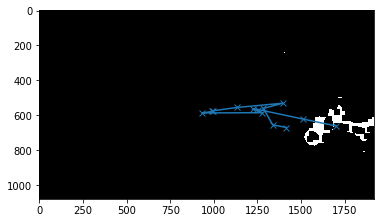

In [9]:
xcm = []
ycm = []

# Recuperando centro de massa das imagens
for key, value in images.items():
    x,y = value[MASS]
    xcm.append(x)
    ycm.append(y)

# Recuperando primeira imagem
gray = images['shot0003.png'][RESULT]

# Plotando imagem
plt.imshow(gray, 'gray')     

# Plotando trajetória
plt.plot(xcm, ycm, 'x-')